# MultiLayer Perceptrons

## Activation functions

Activation functions determine if a neuron should fire by applying a bias after computing the weighted sum of its inputs.

In [24]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

### ReLU Function

The ReLU function keeps positive values as they are, while replacing all negative values with zero.

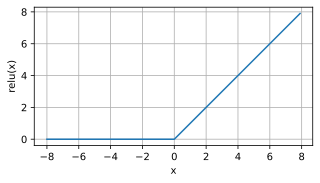

In [25]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)

d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

We plot the derivative of the ReLU function below.

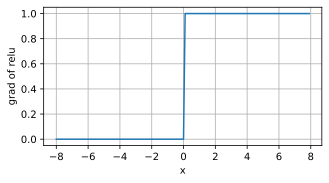

In [26]:
y.backward(torch.ones_like(x), retain_graph=True)

d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

 ------------------------ YOUR TURN -----------------------
 
Implement a pReLU activation function and plot varying the alpha parameter.

PReLU = Parametric ReLU

PReLU is a variant of ReLU that allows the slope of the negative part to be learned during training.
It is defined as 
* `f(x) = max(0, x)` for `x >= 0` and 
* `f(x) = weight * x` for `x < 0` 

where weight is a learnable parameter. 

In [27]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.prelu(x, weight=torch.tensor(0.1))  # PReLU activation function
y2 = torch.prelu(x, weight=torch.tensor(0.3))  # PReLU activation function

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(x.detach(), y.detach(), label='f(x) = PReLU(x, 0.1)')
plt.plot(x.detach(), y2.detach(), label='f(x) = PReLU(x, 0.3)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('PReLU Activation Function')
plt.legend()

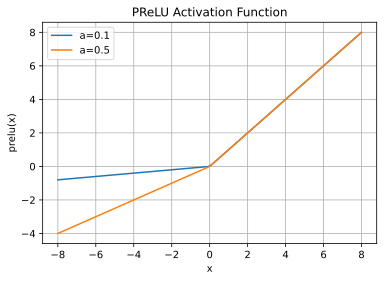

In [28]:
plt.figure(figsize=(6, 4))
plt.plot(x.detach().numpy(), y1.detach().numpy(), label='a=0.1')
plt.plot(x.detach().numpy(), y2.detach().numpy(), label='a=0.5')
plt.title('PReLU Activation Function')
plt.xlabel('x')
plt.ylabel('prelu(x)')
plt.legend()
plt.grid()
plt.show()

### Sigmoid Function

The sigmoid function transforms those inputs whose values lie in the domain $\mathbb{R}$, to outputs that lie on the interval (0, 1). The form of the function is:
$$sigmoid(x) = \frac{1}{1+ e^{-x}}$$

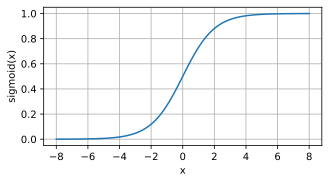

In [29]:
y = torch.sigmoid(x)

d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

The derivative of sigmoid function could be calculated as below:
$$\frac{d}{dx}sigmoid(x) =  sigmoid(x)(1-sigmoid(x))$$

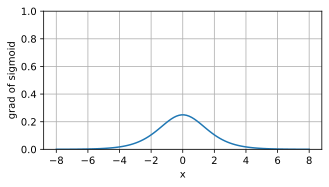

In [33]:
# Clear out previous gradients
y.backward(torch.ones_like(x), retain_graph=True)

d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5), ylim=(0,1))

### Tanh Function

Similar to the sigmoid, the tanh (hyperbolic tangent) function compresses its inputs, mapping them to outputs within the interval 
$(−1,1)$:
$$tanh(x) = \frac{1-e^{-2x}}{1+e^{-2x}}$$

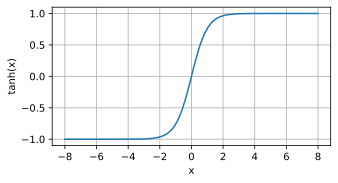

In [34]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

The derivative of the tanh function is:
$$\frac{d}{dx}tanh(x) = 1 - tanh^{2}(x)$$

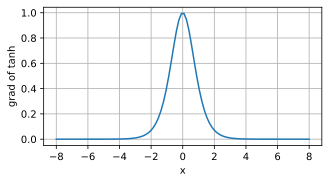

In [35]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

## Implementation of Multilayer Perceptrons

### From scratch

#### Initializing Model Parameters

Fashion-MNIST is treated as a classification task with 784 input features and 10 classes. We implement an MLP with one hidden layer of 256 units, noting that layer size and depth are tunable hyperparameters. Each layer requires a weight matrix and bias vector, along with memory for their gradients.

In [36]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

#### Model

To fully understand its mechanics, we will code the ReLU activation manually instead of relying on the built-in relu function.

In [37]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

Because we ignore spatial structure, each 2D image is flattened into a vector of length num_inputs. With autograd handling differentiation, the model can then be implemented in just a few lines of code.

In [38]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

#### Training

Luckily, training an MLP follows the same loop as softmax regression: we set up the model, data, and trainer, and then call the fit method to run training.

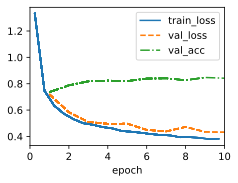

In [39]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

### Concise Implementation

As expected, using high-level APIs allows us to implement MLPs in an even more compact way.

#### Model

Here, the only change is adding two fully connected layers instead of one: a hidden layer followed by an output layer.

In [40]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

#### Training

This modular design lets us keep model architecture independent from other considerations.

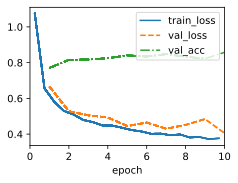

In [41]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

## Numerical Stability and Initialization

So far, we have used parameter initialization without much discussion, but the choice of initialization is critical. It affects numerical stability, interacts with activation functions, and influences optimization speed. Poor initialization can lead to exploding or vanishing gradients, so this section explores these issues and provides practical heuristics.

### Vanishing and Exploding Gradients

In deep networks, gradients are computed as products of many matrices. This can lead to numerical instability, where the gradients become either extremely large (exploding gradients) or extremely small (vanishing gradients). Such unstable gradients harm optimization by causing destructive parameter updates or preventing learning altogether.

#### Vanishing Gradients

A major cause of the vanishing gradient problem is the choice of activation function applied after each layer. Historically, the sigmoid function was widely used because it resembled biological thresholding behavior, neurons firing fully or not at all. However, this choice often leads to vanishing gradients, as we will now examine more closely.

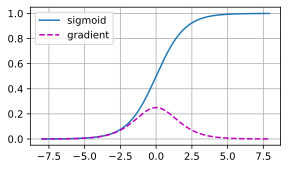

In [42]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

The sigmoid’s gradient vanishes for both very large and very small inputs. When backpropagating through many layers, unless the inputs stay in a narrow middle range, the gradients tend to disappear, often cutting off learning at some depth. This issue long hindered deep network training. ReLUs, while less biologically realistic, avoid this instability and have therefore become the standard choice.

#### Exploding Gradients

The opposite issue, exploding gradients, can be just as problematic. For example, multiplying many Gaussian random matrices by an initial matrix causes the result to grow uncontrollably when the variance is set to 1. If this occurs during network initialization, gradient descent cannot converge.

In [43]:
M = torch.normal(0, 1, size=(4, 4))
print('a single matrix \n',M)
for i in range(100):
    M = M @ torch.normal(0, 1, size=(4, 4))
print('after multiplying 100 matrices\n', M)

a single matrix 
 tensor([[ 1.2014, -0.2658,  0.3928,  1.5069],
        [ 0.1650,  0.9688, -0.3798,  1.7380],
        [ 0.6076, -0.0241,  1.3173,  0.3315],
        [ 1.3120, -0.0448, -1.9781,  1.5641]])
after multiplying 100 matrices
 tensor([[-8.0054e+21, -3.2791e+22, -2.9650e+22, -3.3904e+22],
        [-1.0640e+21, -4.3584e+21, -3.9417e+21, -4.5071e+21],
        [-4.5889e+21, -1.8796e+22, -1.6995e+22, -1.9433e+22],
        [-2.8303e+21, -1.1593e+22, -1.0487e+22, -1.1990e+22]])


### Parameter Initialization

Parameter initialization is crucial for stable training. Default initialization often uses random values from a normal distribution, but this can lead to exploding or vanishing variances across layers. Xavier initialization (Glorot and Bengio, 2010) addresses this by scaling weights based on both the number of input and output units, ensuring balanced variance during forward and backward propagation. It typically samples from a Gaussian or uniform distribution with variance $2 / (n_{in} + n_{out})$, making it a widely used and effective method in practice.

## Dropout

A good predictive model should generalize well by being simple and robust to input noise. Bishop (1995) showed that training with noise is equivalent to regularization, making models smoother and more resilient. Building on this, Srivastava et al. (2014) introduced dropout, which randomly zeros out neurons during training to prevent overfitting and break co-adaptation between units. Standard dropout keeps the expected output unbiased by rescaling activations, and it has become a widely used regularization method in deep learning.

### Implementation from scratch

To implement dropout for a layer, we sample from a Bernoulli distribution: each unit is kept with probability $1 - p$ and dropped with probability $p$. Practically, this can be done by drawing uniform random numbers and retaining units whose sample exceeds $p$. In code, a `dropout_layer` function drops elements of input $X$ with probability `dropout` and rescales the survivors by dividing by `1 - dropout` .

In [44]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

We can try out the `dropout_layer` function on some sample inputs by applying dropout with probabilities of 0, 0.5, and 1, respectively.

In [45]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  2.,  4.,  0.,  0.,  0., 12.,  0.],
        [16.,  0., 20.,  0.,  0., 26.,  0.,  0.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


#### Model

In the model below, dropout is applied to the outputs of each hidden layer after activation. The dropout probability can be set individually for each layer, with smaller values often used near the input. Importantly, dropout is enabled only during training, not during inference.

In [46]:
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

#### Training

The training process here follows the same procedure as that used for MLPs discussed earlier.

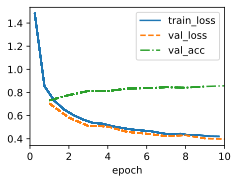

In [47]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

### Concise Implementation

Using high-level APIs, dropout is implemented by adding a Dropout layer after each fully connected layer, with the dropout probability as its sole parameter. During training, it randomly zeros out outputs of the previous layer, while in testing it passes data through unchanged.

In [48]:
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

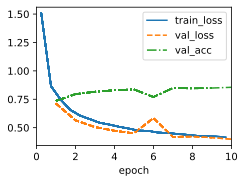

In [49]:
model = DropoutMLP(**hparams)
trainer.fit(model, data)

## Exercises

### Ex.1 

Provide an example where the gradients vanish for the sigmoid activation function.

### Ex.2
Why is it a bad idea to insert a hidden layer with a single neuron? What could go wrong?


### Ex.3
Can we initialize all weight parameters in linear regression or in softmax regression to the same value?


### Ex.4 
Why is dropout not typically used at test time?